# Loading the data

In [1]:
!pip install datasets evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


## Transforming the DataFrames into DataLoaders

In [2]:
import transformers
import pandas as pd
import numpy as np

In [3]:
data = pd.read_csv("news_processed_spacy.csv")

In [4]:
data.columns

Index(['text', 'polarity', 'n_tokens', 'total_n_ents', 'n_org_ents',
       'n_per_ents', 'n_gpe_ents', 'n_norp_ents', 'n_date_ents', 'entities',
       'org_ents', 'per_ents', 'gpe_ents', 'norp_ents', 'date_ents'],
      dtype='object')

In [5]:
data = data[["text", "polarity"]]
data.rename({"polarity": "labels"}, axis=1, inplace=True)

<ipython-input-5-8ddbe44b7076>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.rename({"polarity": "labels"}, axis=1, inplace=True)


In [6]:
data.replace({"True": 1, "Fake":0}, inplace=True)

<ipython-input-6-7bc00af4ed29>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.replace({"True": 1, "Fake":0}, inplace=True)
<ipython-input-6-7bc00af4ed29>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.replace({"True": 1, "Fake":0}, inplace=True)


In [7]:
import json

with open("data_split_indexes.json", "r") as f:
    data_split_indexes = json.load(f)

In [8]:
training_portion = data[data.index.isin(data_split_indexes["training"])]
training_portion.shape

(4434, 2)

In [9]:
testing_portion = data[data.index.isin(data_split_indexes["testing"])]
testing_portion.shape

(950, 2)

In [10]:
validation_portion = data[data.index.isin(data_split_indexes["validation"])]
validation_portion.shape

(950, 2)

In [11]:
label2id = {"True": 1, "Fake":0}
id2label = {value: key for key, value in label2id.items()}

print(id2label)
print(label2id)

{1: 'True', 0: 'Fake'}
{'True': 1, 'Fake': 0}


In [12]:
from datasets import Dataset

train_data = Dataset.from_pandas(training_portion)
validation_data = Dataset.from_pandas(validation_portion)
test_data = Dataset.from_pandas(testing_portion)


In [13]:
train_data

Dataset({
    features: ['text', 'labels', '__index_level_0__'],
    num_rows: 4434
})

In [14]:
train_data[0]

{'text': 'Kerry to go to Paris in gesture of sympathyU.S. Secretary of State John F. Kerry said Monday that he will stop in Paris later this week, amid criticism that no top American officials attended Sunday’s unity march against terrorism.\n\nKerry said he expects to arrive in Paris Thursday evening, as he heads home after a week abroad. He said he will fly to France at the conclusion of a series of meetings scheduled for Thursday in Sofia, Bulgaria. He plans to meet the next day with Foreign Minister Laurent Fabius and President Francois Hollande, then return to Washington.\n\nThe visit by Kerry, who has family and childhood ties to the country and speaks fluent French, could address some of the criticism that the United States snubbed France in its darkest hour in many years.\n\nThe French press on Monday was filled with questions about why neither President Obama nor Kerry attended Sunday’s march, as about 40 leaders of other nations did. Obama was said to have stayed away because

# Transformer Model

In [15]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments, DataCollatorWithPadding

model = "distilbert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model)
model = AutoModelForSequenceClassification.from_pretrained(model, num_labels=2, id2label=id2label, label2id=label2id)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
def preprocess_function(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
    )

processed_train_data = train_data.map(preprocess_function)
processed_validation_data = validation_data.map(preprocess_function)
processed_test_data = test_data.map(preprocess_function)

Map:   0%|          | 0/4434 [00:00<?, ? examples/s]

Map:   0%|          | 0/950 [00:00<?, ? examples/s]

Map:   0%|          | 0/950 [00:00<?, ? examples/s]

In [17]:
processed_train_data = processed_train_data.remove_columns(["text", "__index_level_0__"])
processed_validation_data = processed_validation_data.remove_columns(["text", "__index_level_0__"])
processed_test_data = processed_test_data.remove_columns(["text", "__index_level_0__"])

In [18]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [19]:
import evaluate

f1 = evaluate.load("f1")
precision = evaluate.load("precision")
recall = evaluate.load("recall")

def evaluate(prediction_array):
    logits, labels = prediction_array
    predictions = np.argmax(logits, axis=1)

    f1_score = f1.compute(predictions=predictions, references=labels)
    # precision_score = precision.compute(predictions=predictions, references=labels)
    # recall_score = recall.compute(predictions=predictions, references=labels)

    return f1_score

In [20]:
import torch

torch.cuda.is_available()


True

In [21]:
device = torch.device("cuda")

In [22]:
num_epochs = 10
learning_rate = 0.00002

training_args = TrainingArguments(
    output_dir="Transformer Model",
    learning_rate=learning_rate,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=num_epochs,
    eval_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True
    )

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=processed_train_data,
    eval_dataset=processed_validation_data,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=evaluate,

)

<ipython-input-22-fce070e71223>:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [23]:
!pip install wandb

In [24]:
import os
import wandb

wandb.disabled = True
os.environ['WANDB_DISABLED'] = 'true'



In [25]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Epoch,Training Loss,Validation Loss,F1
1,0.276600,0.209992,0.915464
2,0.101300,0.092947,0.967885
3,0.034900,0.112631,0.974529
4,0.022000,0.113289,0.971942
5,0.009700,0.229283,0.951276
6,0.006800,0.110100,0.976589
7,0.005500,0.129378,0.974586
8,0.001800,0.152420,0.971491
9,0.000500,0.141249,0.972315
10,0.000500,0.140083,0.974473


TrainOutput(global_step=1390, training_loss=0.045955029108541476, metrics={'train_runtime': 2334.3322, 'train_samples_per_second': 18.995, 'train_steps_per_second': 0.595, 'total_flos': 5873604456407040.0, 'train_loss': 0.045955029108541476, 'epoch': 10.0})

In [26]:
trainer.evaluate(processed_test_data)

{'eval_loss': 0.146173894405365,
 'eval_f1': 0.9595854922279793,
 'eval_runtime': 16.2217,
 'eval_samples_per_second': 58.563,
 'eval_steps_per_second': 1.849,
 'epoch': 10.0}

In [27]:
trainer.state.best_metric # 2rd epoch

0.0929468497633934

In [28]:
trainer.state.best_model_checkpoint # 2rd epoch

'Transformer Model/checkpoint-278'

In [29]:
from huggingface_hub import notebook_login

notebook_login()

In [34]:
trainer.model.push_to_hub("alberto-lorente/distilbert-make-believe16")

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/alberto-lorente/distilbert-make-believe16/commit/a510960aa4187ca43de0e8abf81a9b6ab30fee37', commit_message='Upload DistilBertForSequenceClassification', commit_description='', oid='a510960aa4187ca43de0e8abf81a9b6ab30fee37', pr_url=None, repo_url=RepoUrl('https://huggingface.co/alberto-lorente/distilbert-make-believe16', endpoint='https://huggingface.co', repo_type='model', repo_id='alberto-lorente/distilbert-make-believe16'), pr_revision=None, pr_num=None)

More testing

In [35]:
test_labels = list(processed_test_data["labels"])

In [36]:
preds = trainer.predict(processed_test_data)

In [37]:
pred_logits = preds.predictions
pred_labels = np.argmax(pred_logits, axis=1)

In [38]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, f1_score

In [39]:
acc = accuracy_score(pred_labels, test_labels)
acc

0.9589473684210527

In [40]:
f_1 = f1_score(pred_labels, test_labels)
f_1

0.9595854922279793

In [41]:
prec = accuracy_score(pred_labels, test_labels)
prec

0.9589473684210527

In [42]:
rec = recall_score(pred_labels, test_labels)
rec

0.9566115702479339

In [43]:
conf_matrix = confusion_matrix(pred_labels, test_labels)
conf_matrix

array([[448,  18],
       [ 21, 463]])

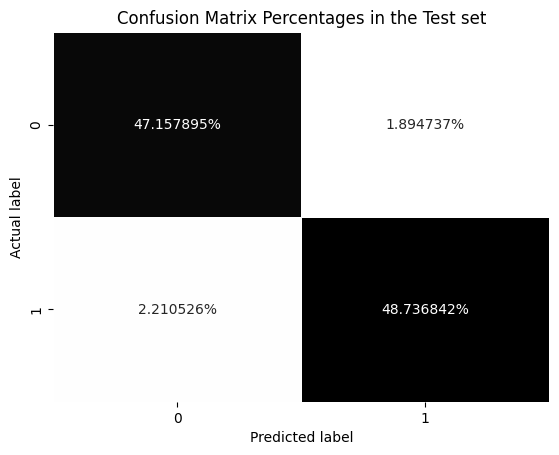

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

cmap = sns.diverging_palette(220, 20, as_cmap = True)

sns.heatmap((conf_matrix/np.sum(conf_matrix)),
            annot=True,
            cbar=False,
            cmap="binary",
            linewidth=.5,
            fmt="%")

plt.title("Confusion Matrix Percentages in the Test set")
plt.ylabel("Actual label")
plt.xlabel("Predicted label")
plt.show()